In [1]:
import numpy as np
import csv
import sys

# replication of the SCM, see https://github.com/kpisti/SCM/tree/v1.0 for details
reader=csv.reader(open("ContactSubgraphMatrix.csv", "r"), delimiter=",")
ta=np.array(list(reader)).astype("int")
reader=csv.reader(open("GapJunctContact.csv", "r"), delimiter=",")
tb=np.array(list(reader)).astype("int")
reader=csv.reader(open("INXExpressionJustContact.csv", "r"), delimiter=",")
tx=np.array(list(reader)).astype("int")
k=np.kron(tx,tx)
taf=ta.flatten()
kp=np.delete(k,np.nonzero(1-taf),0)
tbf=tb.flatten()
tbp=tbf[taf==1]
f = open('workfile.txt', 'w')
kk=np.dot(kp.transpose(),kp)

alpha=0.215
ka=np.linalg.inv(kk+alpha*np.identity(kk.shape[1]))
ka=np.dot(ka,kp.transpose())
ky=np.dot(kp,ka)
tau=np.trace(np.identity(ky.shape[1])-ky)
tof=np.dot(ka,tbp)
r=np.linalg.norm(tbp-np.dot(kp,tof))
obj=r*r/tau/tau
f.write(str(alpha) + "\t" + str(obj) + "\n")
tof=tof.reshape(tx.shape[1],tx.shape[1])
np.savetxt("rule_matrix_"+format(alpha,'.4f')+".csv",tof, delimiter=",")

[]

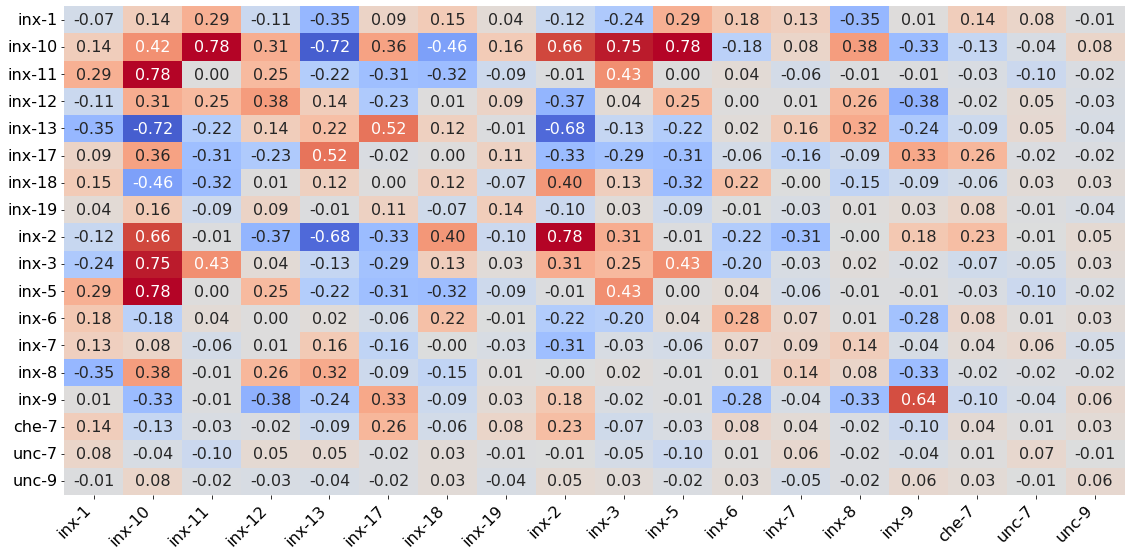

In [2]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 16

# Labels for the heatmap
labels = [
    "inx-1", "inx-10", "inx-11", "inx-12", "inx-13", "inx-17",
    "inx-18", "inx-19", "inx-2", "inx-3", "inx-5", "inx-6",
    "inx-7", "inx-8", "inx-9", "che-7", "unc-7", "unc-9"
]

# Create a heatmap
plt.figure(figsize=(16, 8))  # Adjust the figure size as needed
sns.heatmap(tof, annot=True, fmt=".2f", center = 0.0, cmap='coolwarm', cbar=False, xticklabels=labels, yticklabels=labels)

# Rotate the tick labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.plot()

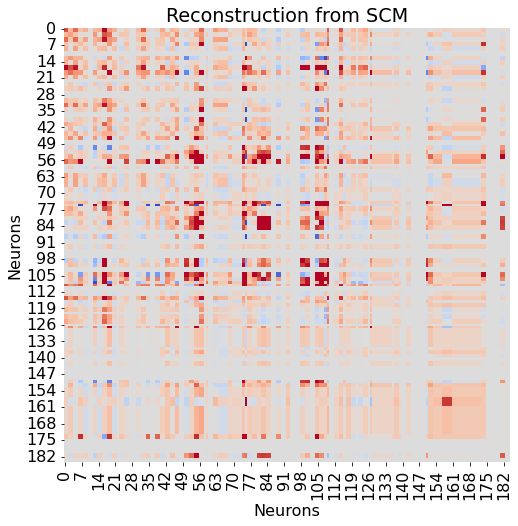

In [3]:
predicted_connectivity = tx.dot(tof).dot(tx.T)
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
heatmap = sns.heatmap(predicted_connectivity, cmap='coolwarm', cbar = False, vmin = -0.5, vmax = 0.5)
axs.set_xlabel('Neurons')
axs.set_ylabel('Neurons')
plt.title ('Reconstruction from SCM')
plt.savefig('figure2_scm_estimated.svg', format='svg', bbox_inches='tight')

In [4]:
from sklearn.metrics import roc_auc_score
roc_auc_score(tbp, kp.dot(tof.flatten()))

0.6428181770033367

In [5]:
triu_indices = np.triu_indices_from(ta, k=0)
sum(ta[triu_indices] == 1)

5592

In [6]:
W = ta
Z = tb
X = Y = tx
A_est = np.load('A_est.npy')
B_est = np.load('B_est.npy')
ABT = A_est.dot(B_est.T)
XABTXT = X.dot(ABT).dot((X.T))

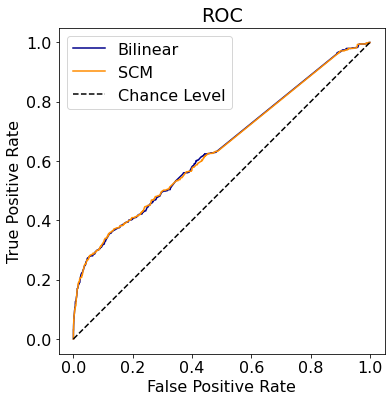

In [7]:
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(6, 6))
RocCurveDisplay.from_predictions(
    Z[W == 1].flatten(), 
    XABTXT[W == 1].flatten(),
    name="Bilinear",
    color="darkblue",
    ax=ax
)

RocCurveDisplay.from_predictions(
    tbp,
    kp.dot(tof.flatten()),
    name="SCM",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(["Bilinear", "SCM", "Chance Level"])
plt.savefig('figure2_ROC_AUC.svg', format='svg', bbox_inches='tight')